# Complete Boston Housing Analysis: Regression



In [18]:
library(mlbench)
library(ggplot2)
library(dplyr)
library(car)


## 1. Data Preparation for Regression

In [19]:
# Load required libraries
# install.packages("caret", dependencies = TRUE)
library(car); library(lmtest); library(caret); library(pROC)
data("BostonHousing2", package = "mlbench")
boston <- BostonHousing2 %>% na.omit()
set.seed(123)
train_index <- createDataPartition(boston$cmedv, p = 0.8, list = FALSE)
train_data <- boston[train_index, ]; test_data <- boston[-train_index, ]
cat("Training:", nrow(train_data), "| Testing:", nrow(test_data), "\n")

Training: 407 | Testing: 99 


## 2. Multiple Linear Regression
### 2.1 Model Building

In [20]:
mlr_model <- lm(cmedv ~ crim + zn + indus + chas + nox + rm + age + dis + rad + tax + ptratio + b + lstat, data = train_data)
summary(mlr_model)


Call:
lm(formula = cmedv ~ crim + zn + indus + chas + nox + rm + age + 
    dis + rad + tax + ptratio + b + lstat, data = train_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-15.2560  -2.8077  -0.5042   1.5970  25.6588 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  37.974163   5.713342   6.647 1.00e-10 ***
crim         -0.090731   0.039410  -2.302 0.021843 *  
zn            0.038493   0.015972   2.410 0.016412 *  
indus         0.003409   0.070064   0.049 0.961213    
chas1         2.377604   0.976334   2.435 0.015326 *  
nox         -16.773431   4.292912  -3.907 0.000110 ***
rm            3.635911   0.457767   7.943 2.10e-14 ***
age          -0.005144   0.015554  -0.331 0.741037    
dis          -1.505096   0.229444  -6.560 1.70e-10 ***
rad           0.316580   0.075307   4.204 3.25e-05 ***
tax          -0.012528   0.004238  -2.956 0.003306 ** 
ptratio      -0.963355   0.149530  -6.443 3.44e-10 ***
b             0.010010   0.0029

### 2.2 Multicollinearity Diagnostics (VIF)

In [32]:
# Calculate VIF values for each predictor
vif_values <- vif(mlr_model)

# Create a data frame with VIF results and status classification
vif_df <- data.frame(
  Variable = names(vif_values), 
  VIF = round(vif_values, 3),
  Status = ifelse(vif_values > 10, "HIGH", 
                  ifelse(vif_values > 5, "MODERATE", "LOW"))
)

# Display VIF values sorted from highest to lowest
print(vif_df[order(-vif_df$VIF), ])

# Create and save the VIF plot
vif_plot <- ggplot(vif_df, aes(x = reorder(Variable, VIF), y = VIF, fill = Status)) + 
  geom_bar(stat = "identity") +
  geom_hline(yintercept = c(5, 10), linetype = "dashed", 
             color = c("orange", "red")) + 
  coord_flip() +
  scale_fill_manual(values = c("LOW" = "green", "MODERATE" = "orange", "HIGH" = "red")) +
  labs(title = "Variance Inflation Factor (VIF) for Predictors", 
       x = "Variables", 
       y = "VIF Value")

# Create assets directory if it doesn't exist
if (!dir.exists("assets")) {
  dir.create("assets")
}

# Save the plot
ggsave("assets/vif_plot.png", plot = vif_plot, width = 8, height = 6, dpi = 300)
cat("Plot saved to assets/vif_plot.png\n")

        Variable   VIF   Status
tax          tax 9.132 MODERATE
rad          rad 7.668 MODERATE
nox          nox 4.370      LOW
indus      indus 4.024      LOW
dis          dis 4.002      LOW
age          age 3.165      LOW
lstat      lstat 3.004      LOW
zn            zn 2.385      LOW
rm            rm 1.916      LOW
ptratio  ptratio 1.848      LOW
crim        crim 1.847      LOW
b              b 1.387      LOW
chas        chas 1.064      LOW


Plot saved to assets/vif_plot.png


In [31]:
mlr_refined <- lm(cmedv ~ crim + zn + indus + chas + nox + rm + age + dis + ptratio + b + lstat, data = train_data)
cat("Refined Model VIF:\n"); print(round(vif(mlr_refined), 3))
summary(mlr_refined)

Refined Model VIF:
   crim      zn   indus    chas     nox      rm     age     dis ptratio       b 
  1.527   2.202   3.322   1.045   3.904   1.874   3.153   4.001   1.545   1.347 
  lstat 
  3.003 



Call:
lm(formula = cmedv ~ crim + zn + indus + chas + nox + rm + age + 
    dis + ptratio + b + lstat, data = train_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-15.3399  -2.6637  -0.6171   1.4096  27.2979 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  31.038180   5.522026   5.621 3.60e-08 ***
crim         -0.039162   0.036553  -1.071  0.28465    
zn            0.033548   0.015654   2.143  0.03271 *  
indus        -0.057459   0.064935  -0.885  0.37676    
chas1         2.783095   0.987219   2.819  0.00506 ** 
nox         -13.614702   4.139227  -3.289  0.00109 ** 
rm            3.904472   0.461775   8.455 5.44e-16 ***
age          -0.009319   0.015834  -0.589  0.55650    
dis          -1.518534   0.234013  -6.489 2.59e-10 ***
ptratio      -0.817212   0.139456  -5.860 9.77e-09 ***
b             0.008810   0.002942   2.995  0.00292 ** 
lstat        -0.541028   0.058845  -9.194  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01

### 2.3 Tests for Regression Coefficients

In [33]:
# Extract coefficient summary from the refined model
coef_summary <- summary(mlr_refined)$coefficients

# Create a formatted data frame with coefficient information
coef_df <- data.frame(
  Variable = rownames(coef_summary), 
  Estimate = round(coef_summary[, 1], 4),
  Std_Error = round(coef_summary[, 2], 4), 
  t_value = round(coef_summary[, 3], 3), 
  p_value = format(coef_summary[, 4], scientific = TRUE),
  Significance = ifelse(coef_summary[, 4] < 0.001, "***", 
                        ifelse(coef_summary[, 4] < 0.01, "**", 
                               ifelse(coef_summary[, 4] < 0.05, "*", "")))
)

# Display the coefficient table
print(coef_df)

# Calculate and display 95% confidence intervals
conf_int <- confint(mlr_refined, level = 0.95)
cat("\n95% Confidence Intervals:\n")
print(round(conf_int, 4))

               Variable Estimate Std_Error t_value      p_value Significance
(Intercept) (Intercept)  31.0382    5.5220   5.621 3.597320e-08          ***
crim               crim  -0.0392    0.0366  -1.071 2.846460e-01             
zn                   zn   0.0335    0.0157   2.143 3.271384e-02            *
indus             indus  -0.0575    0.0649  -0.885 3.767640e-01             
chas1             chas1   2.7831    0.9872   2.819 5.057843e-03           **
nox                 nox -13.6147    4.1392  -3.289 1.094901e-03           **
rm                   rm   3.9045    0.4618   8.455 5.442418e-16          ***
age                 age  -0.0093    0.0158  -0.589 5.564988e-01             
dis                 dis  -1.5185    0.2340  -6.489 2.590285e-10          ***
ptratio         ptratio  -0.8172    0.1395  -5.860 9.768232e-09          ***
b                     b   0.0088    0.0029   2.995 2.920354e-03           **
lstat             lstat  -0.5410    0.0588  -9.194 2.197353e-18          ***

In [34]:
f_stat <- summary(mlr_refined)$fstatistic; p_value <- pf(f_stat[1], f_stat[2], f_stat[3], lower.tail = FALSE)
cat("F-statistic:", f_stat[1], "| p-value:", format(p_value, scientific = TRUE), "\n")

F-statistic: 95.19448 | p-value: 8.717503e-104 


### 2.4 Regression Assumptions

In [35]:
# Set up a 2x2 plot layout
png("assets/regression_diagnostics.png", width = 10, height = 8, units = "in", res = 300)
par(mfrow = c(2, 2), mar = c(4, 4, 3, 2))

# Generate diagnostic plots
plot(mlr_refined, 
    pch = 19, 
    col = rgb(0, 0, 0.5, 0.5),
    cex = 0.8)

par(mfrow = c(1, 1))
dev.off()

cat("Regression diagnostic plots saved to assets/regression_diagnostics.png\n")

pdf 
  2

Regression diagnostic plots saved to assets/regression_diagnostics.png


In [36]:
# Breusch-Pagan test for heteroscedasticity
bp_test <- bptest(mlr_refined)
print(bp_test)
cat("Interpretation:", 
    ifelse(bp_test$p.value < 0.05, 
           "Heteroscedasticity detected (variance is not constant)", 
           "Homoscedasticity OK (variance is constant)"), 
    "\n\n")

# Durbin-Watson test for autocorrelation
dw_test <- durbinWatsonTest(mlr_refined)
print(dw_test)
cat("Interpretation:", 
    ifelse(dw_test$dw < 1.5, "Positive autocorrelation detected",
           ifelse(dw_test$dw > 2.5, "Negative autocorrelation detected",
                  "No significant autocorrelation")), 
    "\n")


	studentized Breusch-Pagan test

data:  mlr_refined
BP = 43.535, df = 11, p-value = 8.763e-06

Interpretation: Heteroscedasticity detected (variance is not constant) 

 lag Autocorrelation D-W Statistic p-value
   1       0.4132442      1.165694       0
 Alternative hypothesis: rho != 0
Interpretation: Positive autocorrelation detected 


### 2.5 Model Performance & Validation

In [37]:
# Make predictions on training and test sets
train_pred <- predict(mlr_refined, train_data)
test_pred <- predict(mlr_refined, test_data)

# Calculate RMSE (Root Mean Squared Error) for both sets
train_rmse <- sqrt(mean((train_data$cmedv - train_pred)^2))
test_rmse <- sqrt(mean((test_data$cmedv - test_pred)^2))

# Calculate R² scores
train_r2 <- summary(mlr_refined)$r.squared
test_r2 <- 1 - sum((test_data$cmedv - test_pred)^2) / sum((test_data$cmedv - mean(test_data$cmedv))^2)

# Calculate Adjusted R² scores
train_adj_r2 <- summary(mlr_refined)$adj.r.squared

# Calculate adjusted R² for test set
n_test <- nrow(test_data)
p <- length(coef(mlr_refined)) - 1  # number of predictors (excluding intercept)
test_adj_r2 <- 1 - ((1 - test_r2) * (n_test - 1) / (n_test - p - 1))

# Display performance metrics
cat("========== MODEL PERFORMANCE ==========\n")
cat("TRAINING SET:\n")
cat("  RMSE:         ", round(train_rmse, 4), "\n")
cat("  R²:           ", round(train_r2, 4), "\n")
cat("  Adjusted R²:  ", round(train_adj_r2, 4), "\n\n")

cat("TEST SET:\n")
cat("  RMSE:         ", round(test_rmse, 4), "\n")
cat("  R²:           ", round(test_r2, 4), "\n")
cat("  Adjusted R²:  ", round(test_adj_r2, 4), "\n")
cat("=======================================\n")

========== MODEL PERFORMANCE ==========
TRAINING SET:
  RMSE:          4.8572 
  R²:            0.7261 
  Adjusted R²:   0.7185 

TEST SET:
  RMSE:          4.2658 
  R²:            0.7604 
  Adjusted R²:   0.7301 


Plot saved to assets/actual_vs_predicted.png


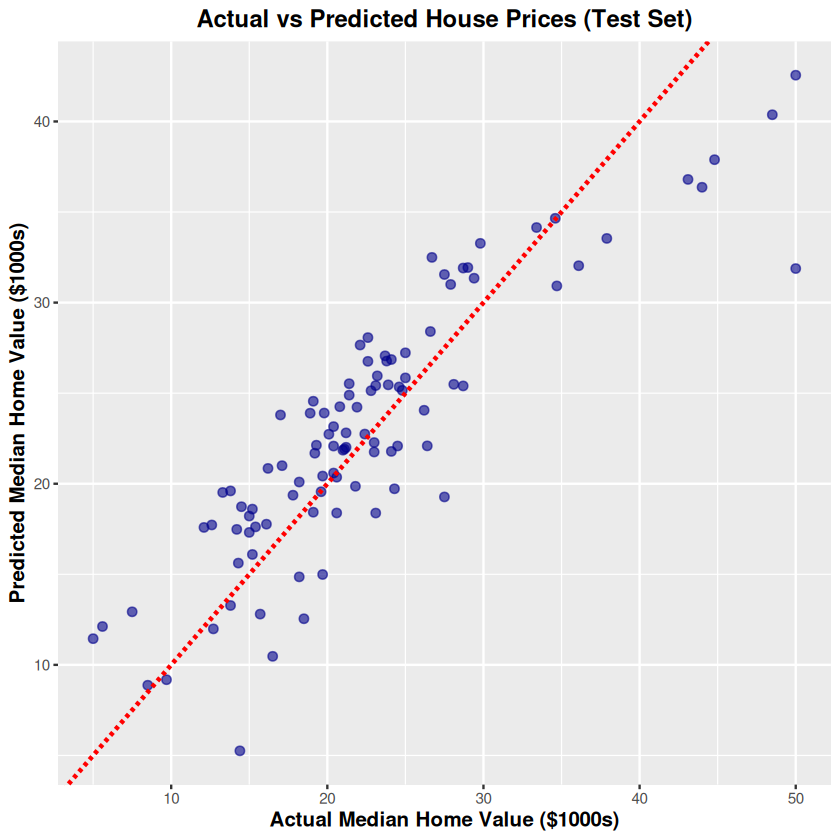

In [40]:
# Create a data frame with actual and predicted values
results_df <- data.frame(Actual = test_data$cmedv, Predicted = test_pred)

# Create the actual vs predicted plot
actual_vs_pred_plot <- ggplot(results_df, aes(x = Actual, y = Predicted)) + 
  geom_point(alpha = 0.6, color = "darkblue", size = 2) +
  geom_abline(intercept = 0, slope = 1, color = "red", linetype = "dashed", size = 1) +
  labs(title = "Actual vs Predicted House Prices (Test Set)", 
       x = "Actual Median Home Value ($1000s)", 
       y = "Predicted Median Home Value ($1000s)") +
  theme(plot.title = element_text(hjust = 0.5, face = "bold", size = 14),
        axis.title = element_text(face = "bold", size = 12))

# Save the plot
ggsave("assets/actual_vs_predicted.png", plot = actual_vs_pred_plot, 
       width = 8, height = 6, dpi = 300)

# Display the plot
print(actual_vs_pred_plot)

cat("Plot saved to assets/actual_vs_predicted.png\n")